In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

from keras.layers import concatenate
from tensorflow.keras.models import Model

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


In [4]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
#from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

In [5]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import max_num_bins, Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve


# AUX FUNCTION TO FIND SOLUTIONS

def dx(fn, x, delta=0.001):
    return (fn(x+delta) - fn(x))/delta

def solvecross(fn, value, x=-45.5, maxtries=1000, maxerr=0.00001):
    for tries in range(maxtries):
        err = fn(x) - value
        if abs(err) < maxerr:
            return x
        slope = dx(fn, x)
        x -= err/slope
    raise ValueError('no solution found')

### Load Data

In [6]:
##############
# PARAMETERS #
##############

tot_B = 634.55+2.26+0.01+0.6+5.34

f_ER = 634.55 / tot_B
f_AC = 2.26 / tot_B
f_CNNS = 0.01 / tot_B
f_RN = 0.6 / tot_B
f_WALL = 5.34 / tot_B

f_ER + f_AC + f_CNNS + f_RN + f_WALL

S_cross1045 = 33.24

cross_factor = np.logspace(-47,-44,10) / 1e-45
S_expected = [max(1, round(S_cross1045 * fac)) for fac in cross_factor]


# DISCOVERY: 'discovery', EXCLUSION: 'exclusion'
D_or_E = 'exclusion'

# requested number of pseudo experiments
num_pseudo = 2000

# number of expected background events per ensemble
B_expected = round(tot_B)

print('B_expected: ', B_expected)
print('S_cross1045: ', S_cross1045)
print('S_expected (from cross=1e-47 to 1e-44): ', S_expected)

B_expected:  643
S_cross1045:  33.24
S_expected (from cross=1e-47 to 1e-44):  [1, 1, 2, 3, 7, 15, 33, 72, 154, 332]


In [7]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

# CHOOSE THE IMAGE SIZE 75 for 75x75 pixels, 128 for 128x128 pixels, 256 for 256x256 pixels
img_size = 75

filename_B = '00-images/ER-img/out-img' + str(img_size) + '/'
filename_B1 = '00-images/AC-img/out-img' + str(img_size) + '/'
filename_B2 = '00-images/CNNS-img/out-img' + str(img_size) + '/'
filename_B3 = '00-images/RN-img/out-img' + str(img_size) + '/'
filename_B4 = '00-images/WALL-img/out-img' + str(img_size) + '/'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 500

filename_S = '00-images/mDM' + str(mDM) + 'GeV-img/out-img' + str(img_size) + '/'

##### Load the h5

In [8]:
# OPEN THE SAVED FILE TO CHECK IT
from PIL import Image

print('\n Background Events shape: ')
    
for i in range(1):
    img = Image.open( filefolder + filename_B + 'ER' + str(i) + '.png' )
    data = np.asarray( img, dtype="int32" )
    print('ER ', data.shape)
    
for i in range(1):
    img = Image.open( filefolder + filename_B1 + 'AC' + str(i) + '.png' )
    data = np.asarray( img, dtype="int32" )
    print('AC ', data.shape)
    
for i in range(1):
    img = Image.open( filefolder + filename_B2 + 'CNNS' + str(i) + '.png' )
    data = np.asarray( img, dtype="int32" )
    print('CNNS ', data.shape)
    
for i in range(1):
    img = Image.open( filefolder + filename_B3 + 'RN' + str(i) + '.png' )
    data = np.asarray( img, dtype="int32" )
    print('RN ', data.shape)
    
for i in range(1):
    img = Image.open( filefolder + filename_B4 + 'WALL' + str(i) + '.png' )
    data = np.asarray( img, dtype="int32" )
    print('WALL ', data.shape)
    
    
print('\n Signal Events shape:')
for i in range(1):
    img = Image.open( filefolder + filename_S + 'WP' + str(i) + '.png' )
    data = np.asarray( img, dtype="int32" )
    print('WIMP ', data.shape)


 Background Events shape: 
ER  (75, 75, 4)
AC  (75, 75, 4)
CNNS  (75, 75, 4)
RN  (75, 75, 4)
WALL  (75, 75, 4)

 Signal Events shape:
WIMP  (75, 75, 4)


In [67]:
################
# ALL THE DATA #
################

# Number of data points (per-class) for the ML classifier
#num_data = 30000
num_data = 5000


NUM_DAT_AC = round(num_data*f_AC)
NUM_DAT_CNNS = max(2, round(num_data*f_CNNS))
NUM_DAT_RN = round(num_data*f_RN)
NUM_DAT_WALL = round(num_data*f_WALL)

NUM_DAT_ER = num_data - ( NUM_DAT_AC + NUM_DAT_CNNS + NUM_DAT_RN + NUM_DAT_WALL )



# load the indeces that are OK (with both S1 and S2 signals)
index_B = np.loadtxt(filefolder + '00-images/ER-img/ok-index.txt').astype(int)
index_B1 = np.loadtxt(filefolder + '00-images/AC-img/ok-index.txt').astype(int)
index_B2 = np.loadtxt(filefolder + '00-images/CNNS-img/ok-index.txt').astype(int)
index_B3 = np.loadtxt(filefolder + '00-images/RN-img/ok-index.txt').astype(int)
index_B4 = np.loadtxt(filefolder + '00-images/WALL-img/ok-index.txt').astype(int)

index_S = np.loadtxt(filefolder + '00-images/mDM' + str(mDM) + 'GeV-img/ok-index.txt').astype(int)



##############
# BACKGROUND #
##############

file_path_B = []

for path_it in range(NUM_DAT_ER):
    file_path_B.append( filefolder + filename_B + 'ER' + str(index_B[path_it]) + '.png' )

# Load the images and convert to a numpy array
images_B0 = [imageio.imread(jj) for jj in file_path_B]
images_B0 = np.asarray(images_B0)



file_path_B1 = []

for path_it in range(NUM_DAT_AC):
    file_path_B1.append( filefolder + filename_B1 + 'AC' + str(index_B1[path_it]) + '.png' )

# Load the images and convert to a numpy array
images_B1 = [imageio.imread(jj) for jj in file_path_B1]
images_B1 = np.asarray(images_B1)



file_path_B2 = []

for path_it in range(NUM_DAT_CNNS):
    file_path_B2.append( filefolder + filename_B2 + 'CNNS' + str(index_B2[path_it]) + '.png' )

# Load the images and convert to a numpy array
images_B2 = [imageio.imread(jj) for jj in file_path_B2]
images_B2 = np.asarray(images_B2)



file_path_B3 = []

for path_it in range(NUM_DAT_RN):
    file_path_B3.append( filefolder + filename_B3 + 'RN' + str(index_B3[path_it]) + '.png' )

# Load the images and convert to a numpy array
images_B3 = [imageio.imread(jj) for jj in file_path_B3]
images_B3 = np.asarray(images_B3)



file_path_B4 = []

for path_it in range(NUM_DAT_WALL):
    file_path_B4.append( filefolder + filename_B4 + 'WALL' + str(index_B4[path_it]) + '.png' )

# Load the images and convert to a numpy array
images_B4 = [imageio.imread(jj) for jj in file_path_B4]
images_B4 = np.asarray(images_B4)



# Concatenate all background contributions
images_B = np.concatenate([images_B0, images_B1, images_B2, images_B3, images_B4])





##########
# SIGNAL #
##########

file_path_S = []

for path_it in range(num_data):
    file_path_S.append( filefolder + filename_S + 'WP' + str(index_S[path_it]) + '.png' )

# Load the images and convert to a numpy array
images_S = [imageio.imread(jj) for jj in file_path_S]
images_S = np.asarray(images_S)




# LABELS
labels_B = np.zeros(len(images_B))
labels_S = np.ones(len(images_S))


print('images_B.shape: ', images_B.shape)
print('images_S.shape: ', images_S.shape)
print('labels_B.shape: ', labels_B.shape)
print('labels_S.shape: ', labels_S.shape)




# CONCATENATE INTO A SINGLE DATASET
images = np.concatenate([images_B, images_S])
del images_B
del images_S

labels = np.concatenate([labels_B,labels_S])
del labels_B
del labels_S



print('\nimages.shape: ', images.shape)
print('labels.shape: ', labels.shape)

# Get image size
image_size = np.asarray([images.shape[1], images.shape[2], images.shape[3]])
print('image_size: ', image_size)

# Scale images so values are between 0 and 1
images = images / 255

n_images = images.shape[0]

images_B.shape:  (5000, 75, 75, 4)
images_S.shape:  (5000, 75, 75, 4)
labels_B.shape:  (5000,)
labels_S.shape:  (5000,)

images.shape:  (10000, 75, 75, 4)
labels.shape:  (10000,)
image_size:  [75 75  4]


##### Load the compressed features

In [13]:
###############
# BACKGROUNDS # 
###############

B_pbot_ER = np.loadtxt(filefolder + 'ER/pbot.txt')
B_ptop_ER = np.loadtxt(filefolder + 'ER/ptop.txt')
B_ppeakS1_ER = np.loadtxt(filefolder + 'ER/ppeakS1.txt')
B_ppeakS2_ER = np.loadtxt(filefolder + 'ER/ppeakS2.txt')

print('B_pbot_ER.shape: ', B_pbot_ER.shape)
print('B_ptop_ER.shape: ', B_ptop_ER.shape)
print('B_ppeakS1_ER.shape :', B_ppeakS1_ER.shape)
print('B_ppeakS2_ER.shape: ', B_ppeakS2_ER.shape)


B_pbot_AC = np.loadtxt(filefolder + 'AC/pbot.txt')
B_ptop_AC = np.loadtxt(filefolder + 'AC/ptop.txt')
B_ppeakS1_AC = np.loadtxt(filefolder + 'AC/ppeakS1.txt')
B_ppeakS2_AC = np.loadtxt(filefolder + 'AC/ppeakS2.txt')

print('\nB_pbot_AC.shape: ', B_pbot_AC.shape)
print('B_ptop_AC.shape: ', B_ptop_AC.shape)
print('B_ppeakS1_AC.shape :', B_ppeakS1_AC.shape)
print('B_ppeakS2_AC.shape: ', B_ppeakS2_AC.shape)


B_pbot_CNNS = np.loadtxt(filefolder + 'CNNS/pbot.txt')
B_ptop_CNNS = np.loadtxt(filefolder + 'CNNS/ptop.txt')
B_ppeakS1_CNNS = np.loadtxt(filefolder + 'CNNS/ppeakS1.txt')
B_ppeakS2_CNNS = np.loadtxt(filefolder + 'CNNS/ppeakS2.txt')

print('\nB_pbot_CNNS.shape: ', B_pbot_CNNS.shape)
print('B_ptop_CNNS.shape: ', B_ptop_CNNS.shape)
print('B_ppeakS1_CNNS.shape :', B_ppeakS1_CNNS.shape)
print('B_ppeakS2_CNNS.shape: ', B_ppeakS2_CNNS.shape)


B_pbot_RN = np.loadtxt(filefolder + 'RN/pbot.txt')
B_ptop_RN = np.loadtxt(filefolder + 'RN/ptop.txt')
B_ppeakS1_RN = np.loadtxt(filefolder + 'RN/ppeakS1.txt')
B_ppeakS2_RN = np.loadtxt(filefolder + 'RN/ppeakS2.txt')

print('\nB_pbot_RN.shape: ', B_pbot_RN.shape)
print('B_ptop_RN.shape: ', B_ptop_RN.shape)
print('B_ppeakS1_RN.shape :', B_ppeakS1_RN.shape)
print('B_ppeakS2_RN.shape: ', B_ppeakS2_RN.shape)


B_pbot_WALL = np.loadtxt(filefolder + 'WALL/pbot.txt')
B_ptop_WALL = np.loadtxt(filefolder + 'WALL/ptop.txt')
B_ppeakS1_WALL = np.loadtxt(filefolder + 'WALL/ppeakS1.txt')
B_ppeakS2_WALL = np.loadtxt(filefolder + 'WALL/ppeakS2.txt')

print('\nB_pbot_WALL.shape: ', B_pbot_WALL.shape)
print('B_ptop_WALL.shape: ', B_ptop_WALL.shape)
print('B_ppeakS1_WALL.shape :', B_ppeakS1_WALL.shape)
print('B_ppeakS2_WALL.shape: ', B_ppeakS2_WALL.shape)


##########
# SIGNAL #
##########

S_pbot = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/pbot.txt')
S_ptop = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ptop.txt')
S_ppeakS1 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS1.txt')
S_ppeakS2 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS2.txt')

print('\nS_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot_ER.shape:  (35549,)
B_ptop_ER.shape:  (35549,)
B_ppeakS1_ER.shape : (35549, 8)
B_ppeakS2_ER.shape:  (35549, 8)

B_pbot_AC.shape:  (3998,)
B_ptop_AC.shape:  (3998,)
B_ppeakS1_AC.shape : (3998, 8)
B_ppeakS2_AC.shape:  (3998, 8)

B_pbot_CNNS.shape:  (99,)
B_ptop_CNNS.shape:  (99,)
B_ppeakS1_CNNS.shape : (99, 8)
B_ppeakS2_CNNS.shape:  (99, 8)

B_pbot_RN.shape:  (2610,)
B_ptop_RN.shape:  (2610,)
B_ppeakS1_RN.shape : (2610, 8)
B_ppeakS2_RN.shape:  (2610, 8)

B_pbot_WALL.shape:  (4642,)
B_ptop_WALL.shape:  (4642,)
B_ppeakS1_WALL.shape : (4642, 8)
B_ppeakS2_WALL.shape:  (4642, 8)

S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 8)
S_ppeakS2.shape:  (32015, 8)



B_pbot.shape:  (5000,)
B_ptop.shape:  (5000,)
B_ppeakS1.shape : (5000, 8)
B_ppeakS2.shape:  (5000, 8)

S_pbot.shape:  (5000,)
S_ptop.shape:  (5000,)
S_ppeakS1.shape : (5000, 8)
S_ppeakS2.shape:  (5000, 8)


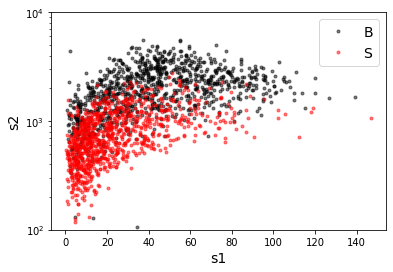

B_pdiffT.shape:  (5000,)
S_pdiffT.shape:  (5000,)


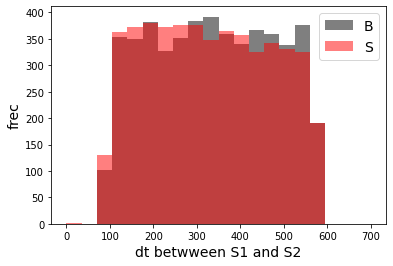

In [14]:

# CONCATENATE THE BACKGROUNDS
B_pbot = np.concatenate([B_pbot_ER[:NUM_DAT_ER], B_pbot_AC[:NUM_DAT_AC], B_pbot_CNNS[:NUM_DAT_CNNS], B_pbot_RN[:NUM_DAT_RN], B_pbot_WALL[:NUM_DAT_WALL]])
B_ptop = np.concatenate([B_ptop_ER[:NUM_DAT_ER], B_ptop_AC[:NUM_DAT_AC], B_ptop_CNNS[:NUM_DAT_CNNS], B_ptop_RN[:NUM_DAT_RN], B_ptop_WALL[:NUM_DAT_WALL]])
B_ppeakS1 = np.concatenate([B_ppeakS1_ER[:NUM_DAT_ER], B_ppeakS1_AC[:NUM_DAT_AC], B_ppeakS1_CNNS[:NUM_DAT_CNNS], B_ppeakS1_RN[:NUM_DAT_RN], B_ppeakS1_WALL[:NUM_DAT_WALL]])
B_ppeakS2 = np.concatenate([B_ppeakS2_ER[:NUM_DAT_ER], B_ppeakS2_AC[:NUM_DAT_AC], B_ppeakS2_CNNS[:NUM_DAT_CNNS], B_ppeakS2_RN[:NUM_DAT_RN], B_ppeakS2_WALL[:NUM_DAT_WALL]])

print('\nB_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot[:num_data]
S_ptop = S_ptop[:num_data]
S_ppeakS1 = S_ppeakS1[:num_data]
S_ppeakS2 = S_ppeakS2[:num_data]

print('\nS_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)


rnd = 100

B_pbot_plot, B_ptop_plot = shuffle(B_pbot, B_ptop, random_state=rnd)
S_pbot_plot, S_ptop_plot = shuffle(S_pbot, S_ptop, random_state=rnd)

plt.plot(B_pbot_plot[:1000], B_ptop_plot[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_pbot_plot[:1000], S_ptop_plot[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel('s1',fontsize=14)
plt.ylabel('s2',fontsize=14)
plt.legend(fontsize=14)
plt.show()



# CONSTRUCT THE TIME DIFFERENCE BETWEEN PULSES

B_pdiffT = B_ppeakS2[:,0] - B_ppeakS1[:,0]
S_pdiffT = S_ppeakS2[:,0] - S_ppeakS1[:,0]

print('B_pdiffT.shape: ', B_pdiffT.shape)
print('S_pdiffT.shape: ', S_pdiffT.shape)


plt.hist(B_pdiffT, range=[0,700], bins=20, color='black', alpha=0.5, label='B')
plt.hist(S_pdiffT, range=[0,700], bins=20, color='red', alpha=0.5, label='S')
# plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('dt betwween S1 and S2',fontsize=14)
plt.ylabel('frec',fontsize=14)
plt.legend(fontsize=14)
plt.show()

##### Remove the absolute times of each pulse (we just need the time difference between pulses
other variables also can be removed if you want

In [15]:
remove_col = [0] # index = 0 is pT0

B_pbot = B_pbot
B_ptop = B_ptop
B_ppeakS1 = np.delete(B_ppeakS1, remove_col, axis=1)
B_ppeakS2 = np.delete(B_ppeakS2, remove_col, axis=1)

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot
S_ptop = S_ptop
S_ppeakS1 = np.delete(S_ppeakS1, remove_col, axis=1)
S_ppeakS2 = np.delete(S_ppeakS2, remove_col, axis=1)

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (5000,)
B_ptop.shape:  (5000,)
B_ppeakS1.shape : (5000, 7)
B_ppeakS2.shape:  (5000, 7)
S_pbot.shape:  (5000,)
S_ptop.shape:  (5000,)
S_ppeakS1.shape : (5000, 7)
S_ppeakS2.shape:  (5000, 7)


## 1. No compressed features

In [70]:
X_mon = images

print('X_mon.shape: ', X_mon.shape)


# labels
y_mon = labels


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon.shape:  (10000, 75, 75, 4)

X_mon_train :  (6375, 75, 75, 4)
y_mon_train :  (6375,)
X_mon_val :  (1125, 75, 75, 4)
y_mon_val :  (1125,)
X_mon_test :  (2500, 75, 75, 4)
y_mon_test :  (2500,)



### XGBoost

In [78]:
# reshape to train XGBoost ( ALL CHANNELS )

X_mon_train_1D = np.reshape(X_mon_train, (len(X_mon_train), X_mon_train.shape[1]*X_mon_train.shape[2]*X_mon_train.shape[3]) )

X_mon_val_1D = np.reshape(X_mon_val, (len(X_mon_val), X_mon_val.shape[1]*X_mon_val.shape[2]*X_mon_val.shape[3]) )

X_mon_test_1D = np.reshape(X_mon_test, (len(X_mon_test), X_mon_test.shape[1]*X_mon_test.shape[2]*X_mon_test.shape[3]) )

print('X_mon_train_1D.shape: ', X_mon_train_1D.shape)
print('X_mon_val_1D.shape: ', X_mon_val_1D.shape)
print('X_mon_test_1D.shape: ', X_mon_test_1D.shape)

X_mon_train_1D.shape:  (6375, 22500)
X_mon_val_1D.shape:  (1125, 22500)
X_mon_test_1D.shape:  (2500, 22500)


In [88]:
# reshape to train XGBoost ( A SINGLE CHANNEL )

channel = 0

X_mon_train_1D = np.reshape(X_mon_train[:,:,:,channel], (len(X_mon_train), X_mon_train.shape[1]*X_mon_train.shape[2]) )

X_mon_val_1D = np.reshape(X_mon_val[:,:,:,channel], (len(X_mon_val), X_mon_val.shape[1]*X_mon_val.shape[2]) )

X_mon_test_1D = np.reshape(X_mon_test[:,:,:,channel], (len(X_mon_test), X_mon_test.shape[1]*X_mon_test.shape[2]) )

print('X_mon_train_1D.shape: ', X_mon_train_1D.shape)
print('X_mon_val_1D.shape: ', X_mon_val_1D.shape)
print('X_mon_test_1D.shape: ', X_mon_test_1D.shape)

X_mon_train_1D.shape:  (6375, 5625)
X_mon_val_1D.shape:  (1125, 5625)
X_mon_test_1D.shape:  (2500, 5625)


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.65092	validation_1-logloss:0.65586
[1]	validation_0-logloss:0.61537	validation_1-logloss:0.62651
[2]	validation_0-logloss:0.58416	validation_1-logloss:0.59990
[3]	validation_0-logloss:0.55799	validation_1-logloss:0.57852
[4]	validation_0-logloss:0.53369	validation_1-logloss:0.56043
[5]	validation_0-logloss:0.51253	validation_1-logloss:0.54542
[6]	validation_0-logloss:0.49336	validation_1-logloss:0.53185
[7]	validation_0-logloss:0.47686	validation_1-logloss:0.52015
[8]	validation_0-logloss:0.46102	validation_1-logloss:0.50938
[9]	validation_0-logloss:0.44759	validation_1-logloss:0.50075
[10]	validation_0-logloss:0.43498	validation_1-logloss:0.49244
[11]	validation_0-logloss:0.42323	validation_1-logloss:0.48504
[12]	validation_0-logloss:0.41298	validation_1-logloss:0.47916
[13]	validation_0-logloss:0.40307	validation_1-logloss:0.47482
[14]	validation_0-logloss:0.39307	validation_1-logloss:0.46875
[15]	validation_0-logloss:0.38375	validation_1-logloss:0.46404
[1

[130]	validation_0-logloss:0.09111	validation_1-logloss:0.41660
[131]	validation_0-logloss:0.08987	validation_1-logloss:0.41654
[132]	validation_0-logloss:0.08899	validation_1-logloss:0.41672
[133]	validation_0-logloss:0.08840	validation_1-logloss:0.41693
[134]	validation_0-logloss:0.08749	validation_1-logloss:0.41717
[135]	validation_0-logloss:0.08638	validation_1-logloss:0.41754
[136]	validation_0-logloss:0.08554	validation_1-logloss:0.41821
[137]	validation_0-logloss:0.08463	validation_1-logloss:0.41805
[138]	validation_0-logloss:0.08348	validation_1-logloss:0.41798
[139]	validation_0-logloss:0.08235	validation_1-logloss:0.41874
[140]	validation_0-logloss:0.08180	validation_1-logloss:0.41886
[141]	validation_0-logloss:0.08108	validation_1-logloss:0.41933
[142]	validation_0-logloss:0.08044	validation_1-logloss:0.41894
[143]	validation_0-logloss:0.07946	validation_1-logloss:0.41880
[144]	validation_0-logloss:0.07881	validation_1-logloss:0.41884
[145]	validation_0-logloss:0.07823	valid

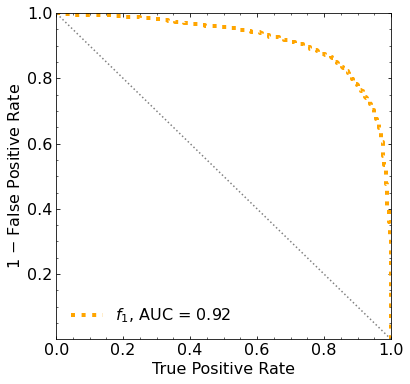

Classification score:


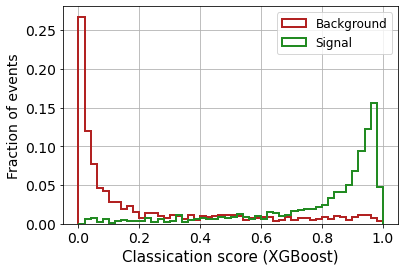


 ROC-AUC =  0.9170699916005982


In [89]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train_1D,y_mon_train,eval_set=[(X_mon_train_1D, y_mon_train), (X_mon_val_1D, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test_1D).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [80]:
# all channels
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9174208202732879


In [90]:
# channel 0
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9170699916005982


In [83]:
# channel 1
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9105540532235264


In [86]:
# channel 2
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9157230143609284


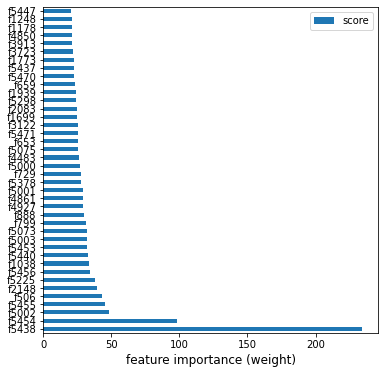

In [87]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 40 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### DNN

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_104 (Dense)            (None, 64)                360064    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_105 (Dense)            (None, 16)                1040      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dropout_82 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_106 (Dense)            (None, 4)               

50/50 [==============================] - 0s 2ms/step - loss: 0.5380 - accuracy: 0.7446 - val_loss: 0.5145 - val_accuracy: 0.7591
Epoch 47/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5542 - accuracy: 0.7265 - val_loss: 0.4999 - val_accuracy: 0.7707
Epoch 48/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5349 - accuracy: 0.7485 - val_loss: 0.5042 - val_accuracy: 0.7582
Epoch 49/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5389 - accuracy: 0.7297 - val_loss: 0.5142 - val_accuracy: 0.7476
Epoch 50/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5167 - accuracy: 0.7565 - val_loss: 0.4896 - val_accuracy: 0.7707
Epoch 51/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.5181 - accuracy: 0.7579 - val_loss: 0.4949 - val_accuracy: 0.7698
Epoch 52/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.5069 - accuracy: 0.7613 - val_loss: 0.4875 - val_accuracy: 0.7707
Epoch 53/1500

50/50 [==============================] - 0s 2ms/step - loss: 0.4975 - accuracy: 0.7723 - val_loss: 0.4752 - val_accuracy: 0.7724
Epoch 104/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4916 - accuracy: 0.7786 - val_loss: 0.4771 - val_accuracy: 0.7813
Epoch 105/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5155 - accuracy: 0.7615 - val_loss: 0.5274 - val_accuracy: 0.7653
Epoch 106/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5145 - accuracy: 0.7778 - val_loss: 0.4926 - val_accuracy: 0.7831
Epoch 107/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5031 - accuracy: 0.7792 - val_loss: 0.4749 - val_accuracy: 0.7804
Epoch 108/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4950 - accuracy: 0.7797 - val_loss: 0.4669 - val_accuracy: 0.7893
Epoch 109/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4918 - accuracy: 0.7757 - val_loss: 0.4792 - val_accuracy: 0.7813
Epoch 1

Epoch 160/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4843 - accuracy: 0.7847 - val_loss: 0.4516 - val_accuracy: 0.7991
Epoch 161/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4839 - accuracy: 0.7857 - val_loss: 0.4520 - val_accuracy: 0.8000
Epoch 162/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5069 - accuracy: 0.7711 - val_loss: 0.4744 - val_accuracy: 0.7787
Epoch 163/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4755 - accuracy: 0.7858 - val_loss: 0.4493 - val_accuracy: 0.7991
Epoch 164/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4741 - accuracy: 0.7878 - val_loss: 0.4721 - val_accuracy: 0.7716
Epoch 165/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4747 - accuracy: 0.7815 - val_loss: 0.4524 - val_accuracy: 0.7929
Epoch 166/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4852 - accuracy: 0.7881 - val_loss: 0.4578 - val_accuracy:

Epoch 217/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4572 - accuracy: 0.7999 - val_loss: 0.4340 - val_accuracy: 0.8071
Epoch 218/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4338 - accuracy: 0.8175 - val_loss: 0.4294 - val_accuracy: 0.8044
Epoch 219/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4528 - accuracy: 0.7964 - val_loss: 0.4299 - val_accuracy: 0.8098
Epoch 220/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4395 - accuracy: 0.8194 - val_loss: 0.4471 - val_accuracy: 0.7982
Epoch 221/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4580 - accuracy: 0.7985 - val_loss: 0.4386 - val_accuracy: 0.7947
Epoch 222/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4419 - accuracy: 0.8131 - val_loss: 0.4413 - val_accuracy: 0.8089
Epoch 223/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4429 - accuracy: 0.8159 - val_loss: 0.4540 - val_accuracy:

Epoch 274/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4181 - accuracy: 0.8228 - val_loss: 0.4147 - val_accuracy: 0.8089
Epoch 275/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4205 - accuracy: 0.8177 - val_loss: 0.4273 - val_accuracy: 0.8027
Epoch 276/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4609 - accuracy: 0.7974 - val_loss: 0.4425 - val_accuracy: 0.7947
Epoch 277/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4524 - accuracy: 0.8051 - val_loss: 0.4121 - val_accuracy: 0.8098
Epoch 278/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4312 - accuracy: 0.8148 - val_loss: 0.4579 - val_accuracy: 0.7920
Epoch 279/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4460 - accuracy: 0.8168 - val_loss: 0.4151 - val_accuracy: 0.8133
Epoch 280/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4440 - accuracy: 0.8075 - val_loss: 0.4190 - val_accuracy:

Epoch 331/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4208 - accuracy: 0.8276 - val_loss: 0.4174 - val_accuracy: 0.8160
Epoch 332/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4096 - accuracy: 0.8332 - val_loss: 0.4291 - val_accuracy: 0.8142
Epoch 333/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4242 - accuracy: 0.8187 - val_loss: 0.4109 - val_accuracy: 0.8142
Epoch 334/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4062 - accuracy: 0.8270 - val_loss: 0.4039 - val_accuracy: 0.8080
Epoch 335/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4259 - accuracy: 0.8174 - val_loss: 0.4095 - val_accuracy: 0.8133
Epoch 336/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4108 - accuracy: 0.8224 - val_loss: 0.4905 - val_accuracy: 0.7724
Epoch 337/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4406 - accuracy: 0.8069 - val_loss: 0.4234 - val_accuracy:

Epoch 388/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4089 - accuracy: 0.8301 - val_loss: 0.4025 - val_accuracy: 0.8204
Epoch 389/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4122 - accuracy: 0.8330 - val_loss: 0.4021 - val_accuracy: 0.8169
Epoch 390/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4022 - accuracy: 0.8304 - val_loss: 0.4086 - val_accuracy: 0.8098
Epoch 391/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4058 - accuracy: 0.8297 - val_loss: 0.4077 - val_accuracy: 0.8116
Epoch 392/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4024 - accuracy: 0.8335 - val_loss: 0.4130 - val_accuracy: 0.8169
Epoch 393/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4143 - accuracy: 0.8253 - val_loss: 0.4242 - val_accuracy: 0.8107
Epoch 394/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4205 - accuracy: 0.8187 - val_loss: 0.4030 - val_accuracy:

Epoch 445/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3974 - accuracy: 0.8291 - val_loss: 0.4003 - val_accuracy: 0.8160
Epoch 446/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4146 - accuracy: 0.8264 - val_loss: 0.4539 - val_accuracy: 0.8027
Epoch 447/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4454 - accuracy: 0.8112 - val_loss: 0.4132 - val_accuracy: 0.8213
Epoch 448/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4065 - accuracy: 0.8264 - val_loss: 0.4120 - val_accuracy: 0.8187
Epoch 449/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4374 - accuracy: 0.8167 - val_loss: 0.4213 - val_accuracy: 0.8044
Epoch 450/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4276 - accuracy: 0.8178 - val_loss: 0.4113 - val_accuracy: 0.8151
Epoch 451/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4143 - accuracy: 0.8171 - val_loss: 0.3981 - val_accuracy:

Epoch 502/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4599 - accuracy: 0.8026 - val_loss: 0.4146 - val_accuracy: 0.8080
Epoch 503/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4294 - accuracy: 0.8174 - val_loss: 0.4094 - val_accuracy: 0.8187
Epoch 504/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4221 - accuracy: 0.8242 - val_loss: 0.4013 - val_accuracy: 0.8142
Epoch 505/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3965 - accuracy: 0.8316 - val_loss: 0.3989 - val_accuracy: 0.8178
Epoch 506/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3933 - accuracy: 0.8345 - val_loss: 0.4394 - val_accuracy: 0.7876
Epoch 507/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4066 - accuracy: 0.8259 - val_loss: 0.4131 - val_accuracy: 0.8071
Epoch 508/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3876 - accuracy: 0.8415 - val_loss: 0.3954 - val_accuracy:

Epoch 559/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3855 - accuracy: 0.8380 - val_loss: 0.4033 - val_accuracy: 0.8178
Epoch 560/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3967 - accuracy: 0.8343 - val_loss: 0.4123 - val_accuracy: 0.8133
Epoch 561/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4027 - accuracy: 0.8269 - val_loss: 0.4118 - val_accuracy: 0.8142
Epoch 562/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3945 - accuracy: 0.8415 - val_loss: 0.4121 - val_accuracy: 0.8187
Epoch 563/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3753 - accuracy: 0.8459 - val_loss: 0.4512 - val_accuracy: 0.8044
Epoch 564/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3934 - accuracy: 0.8330 - val_loss: 0.3956 - val_accuracy: 0.8178
Epoch 565/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4040 - accuracy: 0.8290 - val_loss: 0.4687 - val_accuracy:

Epoch 616/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4031 - accuracy: 0.8355 - val_loss: 0.4112 - val_accuracy: 0.8204
Epoch 617/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3754 - accuracy: 0.8379 - val_loss: 0.4191 - val_accuracy: 0.8053
Epoch 618/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3802 - accuracy: 0.8394 - val_loss: 0.4050 - val_accuracy: 0.8240
Epoch 619/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3820 - accuracy: 0.8381 - val_loss: 0.4074 - val_accuracy: 0.8062
Epoch 620/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4227 - accuracy: 0.8234 - val_loss: 0.3974 - val_accuracy: 0.8151
Epoch 621/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4049 - accuracy: 0.8227 - val_loss: 0.4103 - val_accuracy: 0.8187
Epoch 622/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3827 - accuracy: 0.8390 - val_loss: 0.4148 - val_accuracy:

Epoch 673/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3833 - accuracy: 0.8344 - val_loss: 0.4115 - val_accuracy: 0.8187
Epoch 674/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3891 - accuracy: 0.8442 - val_loss: 0.3974 - val_accuracy: 0.8240
Epoch 675/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3803 - accuracy: 0.8428 - val_loss: 0.4012 - val_accuracy: 0.8222
Epoch 676/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3875 - accuracy: 0.8427 - val_loss: 0.3957 - val_accuracy: 0.8222
Epoch 677/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3799 - accuracy: 0.8414 - val_loss: 0.4031 - val_accuracy: 0.8204
Epoch 678/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3677 - accuracy: 0.8472 - val_loss: 0.4096 - val_accuracy: 0.8089
Epoch 679/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3741 - accuracy: 0.8371 - val_loss: 0.4173 - val_accuracy:

Epoch 730/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3787 - accuracy: 0.8387 - val_loss: 0.4082 - val_accuracy: 0.8196
Epoch 731/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3854 - accuracy: 0.8266 - val_loss: 0.3981 - val_accuracy: 0.8142
Epoch 732/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3755 - accuracy: 0.8357 - val_loss: 0.4091 - val_accuracy: 0.8169
Epoch 733/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3734 - accuracy: 0.8414 - val_loss: 0.4168 - val_accuracy: 0.8231
Epoch 734/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3614 - accuracy: 0.8451 - val_loss: 0.3992 - val_accuracy: 0.8107
Epoch 735/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3862 - accuracy: 0.8370 - val_loss: 0.4288 - val_accuracy: 0.8142
Epoch 736/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3763 - accuracy: 0.8357 - val_loss: 0.4058 - val_accuracy:

Epoch 787/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3861 - accuracy: 0.8338 - val_loss: 0.4894 - val_accuracy: 0.8062
Epoch 788/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3808 - accuracy: 0.8312 - val_loss: 0.4183 - val_accuracy: 0.8133
Epoch 789/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3764 - accuracy: 0.8498 - val_loss: 0.4056 - val_accuracy: 0.8213
Epoch 790/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3544 - accuracy: 0.8478 - val_loss: 0.4107 - val_accuracy: 0.8196
Epoch 791/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3525 - accuracy: 0.8542 - val_loss: 0.4089 - val_accuracy: 0.8204
Epoch 792/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3550 - accuracy: 0.8549 - val_loss: 0.4171 - val_accuracy: 0.8107
Epoch 793/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4035 - accuracy: 0.8278 - val_loss: 0.4084 - val_accuracy:

Epoch 844/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3728 - accuracy: 0.8392 - val_loss: 0.4035 - val_accuracy: 0.8116
Epoch 845/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3821 - accuracy: 0.8308 - val_loss: 0.4121 - val_accuracy: 0.8107
Epoch 846/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3591 - accuracy: 0.8519 - val_loss: 0.4803 - val_accuracy: 0.7893
Epoch 847/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4204 - accuracy: 0.8067 - val_loss: 0.4274 - val_accuracy: 0.8036
Epoch 848/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3961 - accuracy: 0.8262 - val_loss: 0.4153 - val_accuracy: 0.8187
Epoch 849/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3791 - accuracy: 0.8408 - val_loss: 0.4063 - val_accuracy: 0.8213
Epoch 850/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3635 - accuracy: 0.8434 - val_loss: 0.4028 - val_accuracy:

Epoch 901/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3889 - accuracy: 0.8340 - val_loss: 0.4166 - val_accuracy: 0.8027
Epoch 902/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3978 - accuracy: 0.8284 - val_loss: 0.4404 - val_accuracy: 0.8222
Epoch 903/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3751 - accuracy: 0.8425 - val_loss: 0.4012 - val_accuracy: 0.8231
Epoch 904/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3850 - accuracy: 0.8455 - val_loss: 0.4677 - val_accuracy: 0.8222
Epoch 905/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3955 - accuracy: 0.8346 - val_loss: 0.4185 - val_accuracy: 0.8089
Epoch 906/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3835 - accuracy: 0.8398 - val_loss: 0.4141 - val_accuracy: 0.8098
Epoch 907/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3667 - accuracy: 0.8394 - val_loss: 0.4170 - val_accuracy:

Epoch 958/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3611 - accuracy: 0.8477 - val_loss: 0.4058 - val_accuracy: 0.8213
Epoch 959/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3522 - accuracy: 0.8504 - val_loss: 0.3925 - val_accuracy: 0.8213
Epoch 960/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3650 - accuracy: 0.8412 - val_loss: 0.4249 - val_accuracy: 0.8187
Epoch 961/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3778 - accuracy: 0.8430 - val_loss: 0.4022 - val_accuracy: 0.8222
Epoch 962/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3743 - accuracy: 0.8448 - val_loss: 0.4244 - val_accuracy: 0.8053
Epoch 963/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3693 - accuracy: 0.8409 - val_loss: 0.4014 - val_accuracy: 0.8311
Epoch 964/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3602 - accuracy: 0.8462 - val_loss: 0.4050 - val_accuracy:

Epoch 1015/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3566 - accuracy: 0.8428 - val_loss: 0.3996 - val_accuracy: 0.8213
Epoch 1016/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3622 - accuracy: 0.8426 - val_loss: 0.4164 - val_accuracy: 0.7956
Epoch 1017/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3619 - accuracy: 0.8426 - val_loss: 0.4006 - val_accuracy: 0.8258
Epoch 1018/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3552 - accuracy: 0.8547 - val_loss: 0.4265 - val_accuracy: 0.8116
Epoch 1019/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3786 - accuracy: 0.8381 - val_loss: 0.4103 - val_accuracy: 0.8213
Epoch 1020/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3631 - accuracy: 0.8424 - val_loss: 0.4010 - val_accuracy: 0.8284
Epoch 1021/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3607 - accuracy: 0.8457 - val_loss: 0.4032 - val_ac

50/50 [==============================] - 0s 2ms/step - loss: 0.3880 - accuracy: 0.8383 - val_loss: 0.4516 - val_accuracy: 0.7947
Epoch 1072/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3891 - accuracy: 0.8328 - val_loss: 0.4011 - val_accuracy: 0.8187
Epoch 1073/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3611 - accuracy: 0.8441 - val_loss: 0.4007 - val_accuracy: 0.8169
Epoch 1074/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3740 - accuracy: 0.8409 - val_loss: 0.4109 - val_accuracy: 0.8240
Epoch 1075/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3706 - accuracy: 0.8409 - val_loss: 0.4215 - val_accuracy: 0.8213
Epoch 1076/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3717 - accuracy: 0.8336 - val_loss: 0.4449 - val_accuracy: 0.7920
Epoch 1077/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3505 - accuracy: 0.8586 - val_loss: 0.4309 - val_accuracy: 0.8178
E

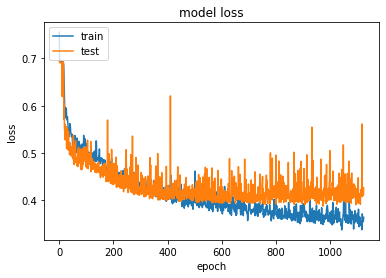

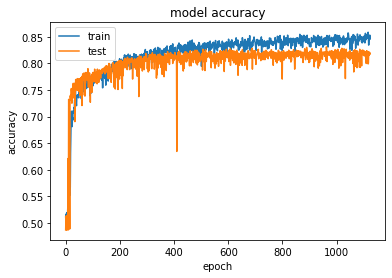

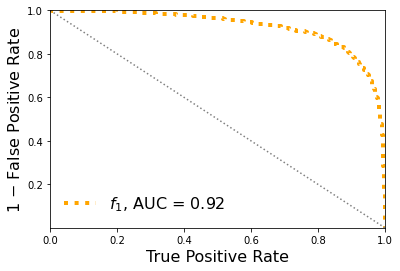

Classification score:


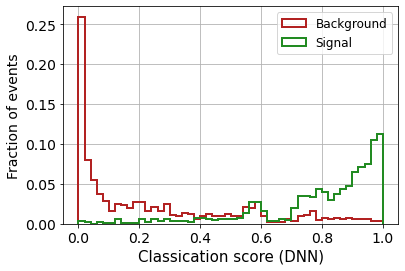


 ROC-AUC =  0.9234745354721078


In [137]:

# define the keras model
model = Sequential()
model.add(Dense(64, input_shape=(X_mon_train_1D.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train_1D,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_1D, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test_1D)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [138]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9234745354721078


### CNN

Epoch 1/500
50/50 [==============================] - 7s 118ms/step - loss: 4.1506 - accuracy: 0.5158 - val_loss: 0.7538 - val_accuracy: 0.7084
Epoch 2/500
50/50 [==============================] - 6s 113ms/step - loss: 0.8304 - accuracy: 0.5937 - val_loss: 0.6857 - val_accuracy: 0.7440
Epoch 3/500
50/50 [==============================] - 6s 115ms/step - loss: 0.7053 - accuracy: 0.7021 - val_loss: 0.6197 - val_accuracy: 0.7556
Epoch 4/500
50/50 [==============================] - 6s 116ms/step - loss: 0.6262 - accuracy: 0.7527 - val_loss: 0.6154 - val_accuracy: 0.7636
Epoch 5/500
50/50 [==============================] - 6s 122ms/step - loss: 0.6012 - accuracy: 0.7647 - val_loss: 0.5861 - val_accuracy: 0.7822
Epoch 6/500
50/50 [==============================] - 6s 121ms/step - loss: 0.5739 - accuracy: 0.7810 - val_loss: 0.5682 - val_accuracy: 0.7964
Epoch 7/500
50/50 [==============================] - 6s 123ms/step - loss: 0.5491 - accuracy: 0.7924 - val_loss: 0.5577 - val_accuracy: 0.7804

Epoch 58/500
50/50 [==============================] - 6s 124ms/step - loss: 0.3796 - accuracy: 0.8835 - val_loss: 0.5760 - val_accuracy: 0.8142
Epoch 59/500
50/50 [==============================] - 6s 124ms/step - loss: 0.3766 - accuracy: 0.8885 - val_loss: 0.5427 - val_accuracy: 0.8169
Epoch 60/500
50/50 [==============================] - 6s 124ms/step - loss: 0.3731 - accuracy: 0.8932 - val_loss: 0.5586 - val_accuracy: 0.8116
Epoch 61/500
50/50 [==============================] - 6s 124ms/step - loss: 0.3714 - accuracy: 0.8952 - val_loss: 0.6215 - val_accuracy: 0.8044
Epoch 62/500
50/50 [==============================] - 6s 123ms/step - loss: 0.3857 - accuracy: 0.8853 - val_loss: 0.5438 - val_accuracy: 0.8196
Epoch 63/500
50/50 [==============================] - 6s 123ms/step - loss: 0.3780 - accuracy: 0.8862 - val_loss: 0.5422 - val_accuracy: 0.8053
Epoch 64/500
50/50 [==============================] - 6s 122ms/step - loss: 0.3812 - accuracy: 0.8854 - val_loss: 0.5537 - val_accuracy:

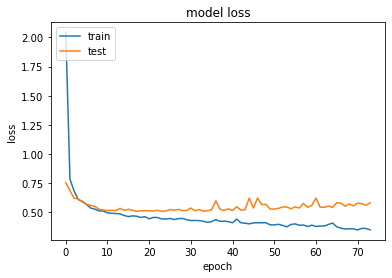

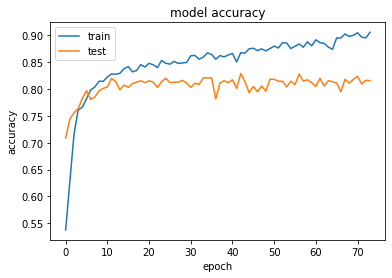

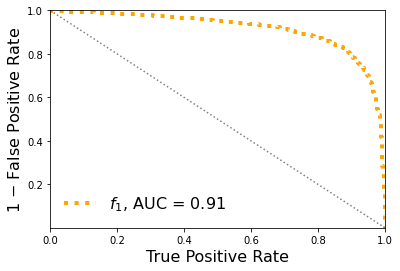

Classification score:


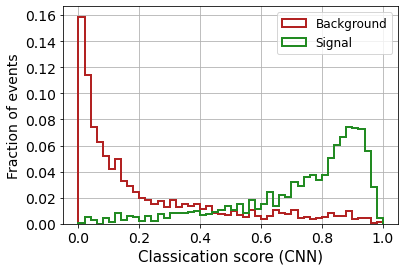


 ROC-AUC =  0.9149330096490688


In [130]:

# define the keras model
model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(X_mon_train.shape[1],X_mon_train.shape[2],X_mon_train.shape[3]), strides = (1,1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling2D((2,2), strides = (1,1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [131]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9149330096490688


## 2. only time diff

In [141]:
# concatenate the data

# all the background features
X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))

# all the signal features
X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')



X_mon5 = np.concatenate([X_mon_B, X_mon_S])

print('X_mon5.shape: ', X_mon5.shape)



# labels
y_mon5 = np.concatenate([np.zeros(num_data),np.ones(num_data)])




# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon5_aux, X_mon5_test, y_mon5_aux, y_mon5_test = train_test_split(X_mon5,
                                                                y_mon5,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon5,
                                                                shuffle=True)



X_mon5_train, X_mon5_val, y_mon5_train, y_mon5_val = train_test_split(X_mon5_aux,
                                                                  y_mon5_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon5_aux,
                                                                  shuffle=True)



print('')
print('X_mon5_train : ', X_mon5_train.shape)
print('y_mon5_train : ', y_mon5_train.shape)
print('X_mon5_val : ', X_mon5_val.shape)
print('y_mon5_val : ', y_mon5_val.shape)
print('X_mon5_test : ', X_mon5_test.shape)
print('y_mon5_test : ', y_mon5_test.shape)
print('')

X_mon_B.shape:  (5000, 1)
X_mon_S.shape:  (5000, 1)

X_mon5.shape:  (10000, 1)

X_mon5_train :  (6375, 1)
y_mon5_train :  (6375,)
X_mon5_val :  (1125, 1)
y_mon5_val :  (1125,)
X_mon5_test :  (2500, 1)
y_mon5_test :  (2500,)



In [143]:
X_mon_train_1D = np.concatenate([X_mon_train_1D, X_mon5_train],axis=1)
X_mon_test_1D = np.concatenate([X_mon_test_1D, X_mon5_test],axis=1)
X_mon_val_1D = np.concatenate([X_mon_val_1D, X_mon5_val],axis=1)




print('')
print('X_mon_train_1D : ', X_mon_train_1D.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val_1D : ', X_mon_val_1D.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test_1D : ', X_mon_test_1D.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train_1D :  (6375, 5627)
y_mon_train :  (6375,)
X_mon_val_1D :  (1125, 5627)
y_mon_val :  (1125,)
X_mon_test_1D :  (2500, 5627)
y_mon_test :  (2500,)



### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.64947	validation_1-logloss:0.65370
[1]	validation_0-logloss:0.61354	validation_1-logloss:0.62267
[2]	validation_0-logloss:0.58130	validation_1-logloss:0.59656
[3]	validation_0-logloss:0.55440	validation_1-logloss:0.57339
[4]	validation_0-logloss:0.52958	validation_1-logloss:0.55349
[5]	validation_0-logloss:0.50825	validation_1-logloss:0.53761
[6]	validation_0-logloss:0.48871	validation_1-logloss:0.52458
[7]	validation_0-logloss:0.47141	validation_1-logloss:0.51305
[8]	validation_0-logloss:0.45542	validation_1-logloss:0.50049
[9]	validation_0-logloss:0.44144	validation_1-logloss:0.49024
[10]	validation_0-logloss:0.42780	validation_1-logloss:0.47987
[11]	validation_0-logloss:0.41516	validation_1-logloss:0.47048
[12]	validation_0-logloss:0.40317	validation_1-logloss:0.46291
[13]	validation_0-logloss:0.39184	validation_1-logloss:0.45675
[14]	validation_0-logloss:0.38182	validation_1-logloss:0.45141
[15]	validation_0-logloss:0.37243	validation_1-logloss:0.44801
[1

[130]	validation_0-logloss:0.05959	validation_1-logloss:0.36150
[131]	validation_0-logloss:0.05881	validation_1-logloss:0.36159
[132]	validation_0-logloss:0.05807	validation_1-logloss:0.36136
[133]	validation_0-logloss:0.05742	validation_1-logloss:0.36072
[134]	validation_0-logloss:0.05654	validation_1-logloss:0.36065
[135]	validation_0-logloss:0.05578	validation_1-logloss:0.36120
[136]	validation_0-logloss:0.05493	validation_1-logloss:0.36109
[137]	validation_0-logloss:0.05412	validation_1-logloss:0.36087
[138]	validation_0-logloss:0.05340	validation_1-logloss:0.36103
[139]	validation_0-logloss:0.05271	validation_1-logloss:0.36112
[140]	validation_0-logloss:0.05209	validation_1-logloss:0.36046
[141]	validation_0-logloss:0.05149	validation_1-logloss:0.36085
[142]	validation_0-logloss:0.05083	validation_1-logloss:0.36072
[143]	validation_0-logloss:0.05029	validation_1-logloss:0.36023
[144]	validation_0-logloss:0.04992	validation_1-logloss:0.36095
[145]	validation_0-logloss:0.04926	valid

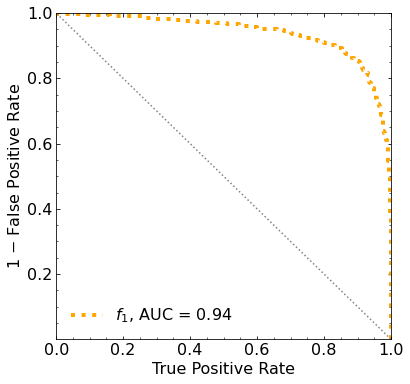

Classification score:


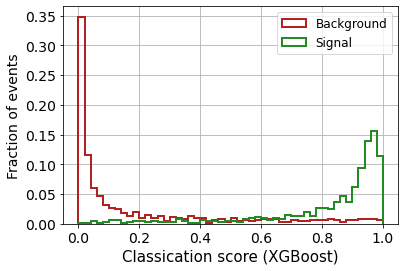


 ROC-AUC =  0.9387643916579601


In [144]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train_1D,y_mon_train,eval_set=[(X_mon_train_1D, y_mon_train), (X_mon_val_1D, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test_1D).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [145]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9387643916579601


### DNN

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 64)                360192    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_84 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_109 (Dense)            (None, 16)                1040      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dropout_85 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 4)               

50/50 [==============================] - 0s 2ms/step - loss: 0.5041 - accuracy: 0.7651 - val_loss: 0.4460 - val_accuracy: 0.8151
Epoch 47/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4845 - accuracy: 0.7894 - val_loss: 0.4343 - val_accuracy: 0.8000
Epoch 48/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4730 - accuracy: 0.7897 - val_loss: 0.4381 - val_accuracy: 0.8116
Epoch 49/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4737 - accuracy: 0.7930 - val_loss: 0.4821 - val_accuracy: 0.7591
Epoch 50/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4923 - accuracy: 0.7751 - val_loss: 0.4297 - val_accuracy: 0.8204
Epoch 51/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4556 - accuracy: 0.7997 - val_loss: 0.4879 - val_accuracy: 0.7662
Epoch 52/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4979 - accuracy: 0.7682 - val_loss: 0.4687 - val_accuracy: 0.8089
Epoch 53/1500

50/50 [==============================] - 0s 2ms/step - loss: 0.4132 - accuracy: 0.8305 - val_loss: 0.3794 - val_accuracy: 0.8364
Epoch 104/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4041 - accuracy: 0.8330 - val_loss: 0.3915 - val_accuracy: 0.8267
Epoch 105/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3982 - accuracy: 0.8402 - val_loss: 0.3874 - val_accuracy: 0.8320
Epoch 106/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4371 - accuracy: 0.8059 - val_loss: 0.3867 - val_accuracy: 0.8364
Epoch 107/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4308 - accuracy: 0.8167 - val_loss: 0.3943 - val_accuracy: 0.8320
Epoch 108/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4339 - accuracy: 0.8117 - val_loss: 0.3786 - val_accuracy: 0.8364
Epoch 109/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4044 - accuracy: 0.8217 - val_loss: 0.4335 - val_accuracy: 0.7884
Epoch 1

Epoch 160/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3889 - accuracy: 0.8421 - val_loss: 0.3465 - val_accuracy: 0.8498
Epoch 161/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3555 - accuracy: 0.8509 - val_loss: 0.3793 - val_accuracy: 0.8400
Epoch 162/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4088 - accuracy: 0.8324 - val_loss: 0.3914 - val_accuracy: 0.8267
Epoch 163/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4068 - accuracy: 0.8297 - val_loss: 0.3574 - val_accuracy: 0.8489
Epoch 164/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3889 - accuracy: 0.8446 - val_loss: 0.3505 - val_accuracy: 0.8409
Epoch 165/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3867 - accuracy: 0.8367 - val_loss: 0.4198 - val_accuracy: 0.8187
Epoch 166/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4022 - accuracy: 0.8408 - val_loss: 0.4075 - val_accuracy:

Epoch 217/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3777 - accuracy: 0.8385 - val_loss: 0.3590 - val_accuracy: 0.8507
Epoch 218/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4001 - accuracy: 0.8255 - val_loss: 0.3716 - val_accuracy: 0.8409
Epoch 219/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3759 - accuracy: 0.8436 - val_loss: 0.3342 - val_accuracy: 0.8613
Epoch 220/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3753 - accuracy: 0.8510 - val_loss: 0.3230 - val_accuracy: 0.8596
Epoch 221/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3472 - accuracy: 0.8690 - val_loss: 0.3408 - val_accuracy: 0.8622
Epoch 222/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3410 - accuracy: 0.8614 - val_loss: 0.3235 - val_accuracy: 0.8560
Epoch 223/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3580 - accuracy: 0.8538 - val_loss: 0.3289 - val_accuracy:

Epoch 274/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3753 - accuracy: 0.8560 - val_loss: 0.3107 - val_accuracy: 0.8711
Epoch 275/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3602 - accuracy: 0.8597 - val_loss: 0.3301 - val_accuracy: 0.8507
Epoch 276/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3389 - accuracy: 0.8656 - val_loss: 0.3267 - val_accuracy: 0.8622
Epoch 277/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3511 - accuracy: 0.8556 - val_loss: 0.3155 - val_accuracy: 0.8702
Epoch 278/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3313 - accuracy: 0.8716 - val_loss: 0.3030 - val_accuracy: 0.8693
Epoch 279/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3317 - accuracy: 0.8730 - val_loss: 0.3069 - val_accuracy: 0.8747
Epoch 280/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3345 - accuracy: 0.8717 - val_loss: 0.3325 - val_accuracy:

Epoch 331/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3284 - accuracy: 0.8645 - val_loss: 0.3130 - val_accuracy: 0.8622
Epoch 332/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3334 - accuracy: 0.8703 - val_loss: 0.3166 - val_accuracy: 0.8658
Epoch 333/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3478 - accuracy: 0.8615 - val_loss: 0.3597 - val_accuracy: 0.8542
Epoch 334/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3633 - accuracy: 0.8553 - val_loss: 0.3110 - val_accuracy: 0.8711
Epoch 335/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3319 - accuracy: 0.8769 - val_loss: 0.3113 - val_accuracy: 0.8676
Epoch 336/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3088 - accuracy: 0.8818 - val_loss: 0.3043 - val_accuracy: 0.8658
Epoch 337/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3549 - accuracy: 0.8502 - val_loss: 0.3057 - val_accuracy:

Epoch 388/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3340 - accuracy: 0.8582 - val_loss: 0.2933 - val_accuracy: 0.8773
Epoch 389/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3097 - accuracy: 0.8782 - val_loss: 0.2962 - val_accuracy: 0.8782
Epoch 390/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3240 - accuracy: 0.8767 - val_loss: 0.4516 - val_accuracy: 0.8302
Epoch 391/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3683 - accuracy: 0.8563 - val_loss: 0.3061 - val_accuracy: 0.8711
Epoch 392/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3252 - accuracy: 0.8610 - val_loss: 0.3017 - val_accuracy: 0.8809
Epoch 393/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3221 - accuracy: 0.8744 - val_loss: 0.3006 - val_accuracy: 0.8693
Epoch 394/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3149 - accuracy: 0.8758 - val_loss: 0.2966 - val_accuracy:

Epoch 445/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2971 - accuracy: 0.8831 - val_loss: 0.3067 - val_accuracy: 0.8676
Epoch 446/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3343 - accuracy: 0.8714 - val_loss: 0.3209 - val_accuracy: 0.8640
Epoch 447/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3353 - accuracy: 0.8635 - val_loss: 0.2888 - val_accuracy: 0.8773
Epoch 448/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3003 - accuracy: 0.8880 - val_loss: 0.3166 - val_accuracy: 0.8684
Epoch 449/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3402 - accuracy: 0.8555 - val_loss: 0.3119 - val_accuracy: 0.8702
Epoch 450/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3030 - accuracy: 0.8873 - val_loss: 0.3570 - val_accuracy: 0.8498
Epoch 451/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3625 - accuracy: 0.8520 - val_loss: 0.3783 - val_accuracy:

Epoch 502/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3037 - accuracy: 0.8768 - val_loss: 0.2977 - val_accuracy: 0.8800
Epoch 503/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3315 - accuracy: 0.8653 - val_loss: 0.3154 - val_accuracy: 0.8756
Epoch 504/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3122 - accuracy: 0.8783 - val_loss: 0.2930 - val_accuracy: 0.8711
Epoch 505/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2966 - accuracy: 0.8842 - val_loss: 0.2913 - val_accuracy: 0.8711
Epoch 506/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2997 - accuracy: 0.8772 - val_loss: 0.3026 - val_accuracy: 0.8604
Epoch 507/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2931 - accuracy: 0.8792 - val_loss: 0.2781 - val_accuracy: 0.8844
Epoch 508/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3018 - accuracy: 0.8776 - val_loss: 0.3227 - val_accuracy:

Epoch 559/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3020 - accuracy: 0.8772 - val_loss: 0.2804 - val_accuracy: 0.8791
Epoch 560/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3016 - accuracy: 0.8728 - val_loss: 0.2957 - val_accuracy: 0.8773
Epoch 561/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3043 - accuracy: 0.8808 - val_loss: 0.3191 - val_accuracy: 0.8720
Epoch 562/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2911 - accuracy: 0.8840 - val_loss: 0.2945 - val_accuracy: 0.8764
Epoch 563/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3230 - accuracy: 0.8703 - val_loss: 0.2895 - val_accuracy: 0.8764
Epoch 564/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.2899 - accuracy: 0.8857 - val_loss: 0.2854 - val_accuracy: 0.8818
Epoch 565/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2850 - accuracy: 0.8777 - val_loss: 0.3041 - val_accuracy:

Epoch 616/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2804 - accuracy: 0.8888 - val_loss: 0.2970 - val_accuracy: 0.8676
Epoch 617/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2842 - accuracy: 0.8852 - val_loss: 0.2947 - val_accuracy: 0.8711
Epoch 618/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3003 - accuracy: 0.8805 - val_loss: 0.3144 - val_accuracy: 0.8613
Epoch 619/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3062 - accuracy: 0.8765 - val_loss: 0.3038 - val_accuracy: 0.8720
Epoch 620/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3015 - accuracy: 0.8787 - val_loss: 0.3054 - val_accuracy: 0.8693
Epoch 621/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2984 - accuracy: 0.8753 - val_loss: 0.2853 - val_accuracy: 0.8738
Epoch 622/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2738 - accuracy: 0.8931 - val_loss: 0.2862 - val_accuracy:

Epoch 673/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.2910 - accuracy: 0.8840 - val_loss: 0.3019 - val_accuracy: 0.8791
Epoch 674/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2734 - accuracy: 0.8968 - val_loss: 0.2909 - val_accuracy: 0.8729
Epoch 675/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2899 - accuracy: 0.8775 - val_loss: 0.2858 - val_accuracy: 0.8818
Epoch 676/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.2948 - accuracy: 0.8836 - val_loss: 0.2954 - val_accuracy: 0.8756
Epoch 677/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2888 - accuracy: 0.8792 - val_loss: 0.2846 - val_accuracy: 0.8756
Epoch 678/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.2828 - accuracy: 0.8882 - val_loss: 0.2870 - val_accuracy: 0.8747
Epoch 679/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2974 - accuracy: 0.8739 - val_loss: 0.2958 - val_accuracy:

Epoch 730/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2662 - accuracy: 0.8876 - val_loss: 0.2805 - val_accuracy: 0.8773
Epoch 731/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2699 - accuracy: 0.8991 - val_loss: 0.2931 - val_accuracy: 0.8773
Epoch 732/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3040 - accuracy: 0.8838 - val_loss: 0.3318 - val_accuracy: 0.8587
Epoch 733/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2751 - accuracy: 0.8902 - val_loss: 0.2992 - val_accuracy: 0.8782
Epoch 734/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3022 - accuracy: 0.8816 - val_loss: 0.2967 - val_accuracy: 0.8711
Epoch 735/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2807 - accuracy: 0.8908 - val_loss: 0.3518 - val_accuracy: 0.8649
Epoch 736/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2798 - accuracy: 0.8849 - val_loss: 0.3319 - val_accuracy:

Epoch 787/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2805 - accuracy: 0.8814 - val_loss: 0.2840 - val_accuracy: 0.8764
Epoch 788/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2760 - accuracy: 0.8904 - val_loss: 0.2740 - val_accuracy: 0.8809
Epoch 789/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2683 - accuracy: 0.8915 - val_loss: 0.2793 - val_accuracy: 0.8738
Epoch 790/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2741 - accuracy: 0.8972 - val_loss: 0.3169 - val_accuracy: 0.8676
Epoch 791/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.2876 - accuracy: 0.8851 - val_loss: 0.2869 - val_accuracy: 0.8693
Epoch 792/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.2748 - accuracy: 0.8921 - val_loss: 0.3697 - val_accuracy: 0.8542
Epoch 793/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3173 - accuracy: 0.8751 - val_loss: 0.3096 - val_accuracy:

Epoch 844/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.2886 - accuracy: 0.8839 - val_loss: 0.2789 - val_accuracy: 0.8756
Epoch 845/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2802 - accuracy: 0.8924 - val_loss: 0.3030 - val_accuracy: 0.8693
Epoch 846/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2834 - accuracy: 0.8901 - val_loss: 0.2868 - val_accuracy: 0.8738
Epoch 847/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3091 - accuracy: 0.8766 - val_loss: 0.3826 - val_accuracy: 0.8604
Epoch 848/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3151 - accuracy: 0.8753 - val_loss: 0.3061 - val_accuracy: 0.8782
Epoch 849/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3210 - accuracy: 0.8657 - val_loss: 0.2837 - val_accuracy: 0.8764
Epoch 850/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2930 - accuracy: 0.8824 - val_loss: 0.2799 - val_accuracy:

Epoch 901/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2772 - accuracy: 0.8913 - val_loss: 0.2797 - val_accuracy: 0.8773
Epoch 902/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2521 - accuracy: 0.8977 - val_loss: 0.3158 - val_accuracy: 0.8711
Epoch 903/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2603 - accuracy: 0.8958 - val_loss: 0.2901 - val_accuracy: 0.8720
Epoch 904/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2630 - accuracy: 0.8947 - val_loss: 0.2852 - val_accuracy: 0.8702
Epoch 905/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2633 - accuracy: 0.8936 - val_loss: 0.3113 - val_accuracy: 0.8684
Epoch 906/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2959 - accuracy: 0.8791 - val_loss: 0.2965 - val_accuracy: 0.8747
Epoch 907/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2708 - accuracy: 0.8895 - val_loss: 0.3026 - val_accuracy:

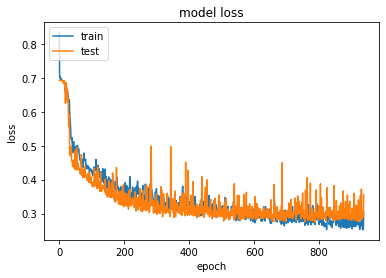

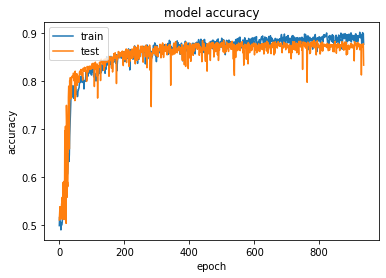

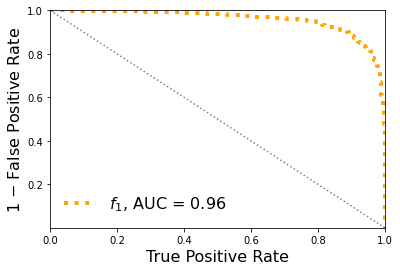

Classification score:


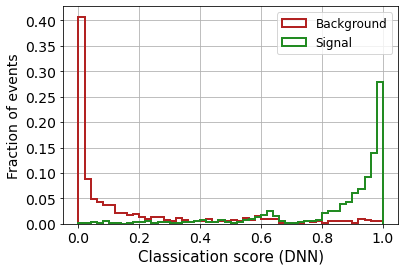


 ROC-AUC =  0.9579472937537131


In [146]:

# define the keras model
model = Sequential()
model.add(Dense(64, input_shape=(X_mon_train_1D.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train_1D,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_1D, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test_1D)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [147]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9579472937537131


### CNN

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 2,656,465
Trainable params: 2,656,465
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/500
50/50 [==============================] - 5s 88ms/step - loss: 4.0072 - accuracy: 0.5321 - val_loss: 0.6564 - val_accuracy: 0.6116
Epoch 2/500
50/50 [==============================] - 4s 89ms/step - loss: 0.5265 - accuracy: 0.7313 - val_loss: 0.5444 - val_accuracy: 0.7449
Epoch 3/500
50/50 [==============================] - 4s 87ms/step - loss: 0.4431 - accuracy: 0.7992 - val_loss: 0.6787 - val_accuracy: 0.6604
Epoch 4/500
50/50 [==============================] - 4s 87ms/step - loss: 0.4473 - accuracy: 0.7917 - val_loss: 0.4467 - val_accuracy: 0.8027
Epoch 5/500
50/50 [=========================

Epoch 55/500
50/50 [==============================] - 4s 90ms/step - loss: 0.0839 - accuracy: 0.9740 - val_loss: 0.4043 - val_accuracy: 0.8649
Epoch 56/500
50/50 [==============================] - 4s 88ms/step - loss: 0.0822 - accuracy: 0.9708 - val_loss: 0.3958 - val_accuracy: 0.8640
Epoch 57/500
50/50 [==============================] - 5s 91ms/step - loss: 0.0781 - accuracy: 0.9755 - val_loss: 0.4010 - val_accuracy: 0.8684
Epoch 58/500
50/50 [==============================] - 5s 90ms/step - loss: 0.0791 - accuracy: 0.9743 - val_loss: 0.4120 - val_accuracy: 0.8658
Epoch 59/500
50/50 [==============================] - 5s 91ms/step - loss: 0.0689 - accuracy: 0.9810 - val_loss: 0.4261 - val_accuracy: 0.8613
Epoch 60/500
50/50 [==============================] - 4s 89ms/step - loss: 0.0683 - accuracy: 0.9777 - val_loss: 0.4335 - val_accuracy: 0.8622
Epoch 61/500
50/50 [==============================] - 5s 91ms/step - loss: 0.0581 - accuracy: 0.9834 - val_loss: 0.4392 - val_accuracy: 0.8667

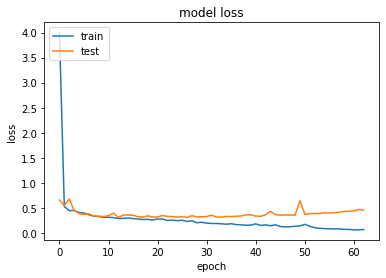

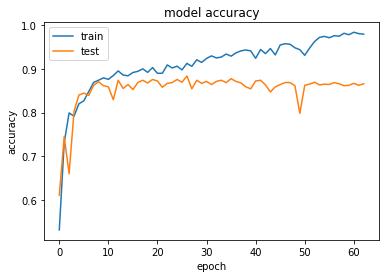

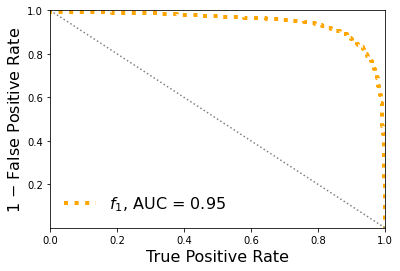

Classification score:


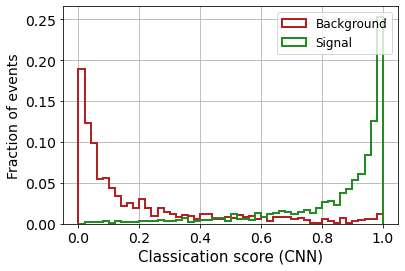


 ROC-AUC =  0.9461663644930653


In [153]:
##########
# images #
##########

input_2d = Input(shape=(X_mon_train.shape[1],X_mon_train.shape[2],X_mon_train.shape[3]))

# Conv1D network
conv2d = Conv2D(16, (3,3), strides = (1),kernel_regularizer=l2(0.005))(input_2d)
conv2d = keras.layers.LeakyReLU(alpha=0.05)(conv2d)
conv2d = MaxPooling2D((2,2), strides = (1,1))(conv2d)

conv2d = Dropout(0.20)(conv2d)
conv2d = Flatten()(conv2d)

conv2d = Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d)
conv2d = keras.layers.LeakyReLU(alpha=0.05)(conv2d)
conv2d = Dropout(0.2)(conv2d)



############
# features #
############

input_1d = Input(shape=(X_mon5_train.shape[1]))



# Concatenate the outputs from Conv2D and Conv1D networks
combined = concatenate([conv2d, input_1d])


# Dense layers
dense = Dense(32, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_2d, input_1d], outputs=output)

# Print the model summary
model.summary()




# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit([X_mon_train,X_mon5_train],
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon_val,X_mon5_val], y_mon_val),
                    shuffle=True)



# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict([X_mon_test,X_mon5_test])

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [154]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9461663644930653


## 3. All compressed features

In [155]:
# concatenate the data

# all the background features
X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)), np.reshape(B_pdiffT,(len(B_pdiffT),1)) ],axis=1)

# all the signal features
X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)), np.reshape(S_pdiffT,(len(S_pdiffT),1)) ],axis=1)

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')

del B_ppeakS1
del B_ppeakS2
del B_pbot
del B_ptop

del S_ppeakS1
del S_ppeakS2
del S_pbot
del S_ptop


X_mon5 = np.concatenate([X_mon_B, X_mon_S])

print('X_mon5.shape: ', X_mon5.shape)
del X_mon_B
del X_mon_S


# labels
y_mon5 = np.concatenate([np.zeros(num_data),np.ones(num_data)])




# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon5_aux, X_mon5_test, y_mon5_aux, y_mon5_test = train_test_split(X_mon5,
                                                                y_mon5,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon5,
                                                                shuffle=True)

del X_mon5
del y_mon5

X_mon5_train, X_mon5_val, y_mon5_train, y_mon5_val = train_test_split(X_mon5_aux,
                                                                  y_mon5_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon5_aux,
                                                                  shuffle=True)

del X_mon5_aux
del y_mon5_aux

print('')
print('X_mon5_train : ', X_mon5_train.shape)
print('y_mon5_train : ', y_mon5_train.shape)
print('X_mon5_val : ', X_mon5_val.shape)
print('y_mon5_val : ', y_mon5_val.shape)
print('X_mon5_test : ', X_mon5_test.shape)
print('y_mon5_test : ', y_mon5_test.shape)
print('')

X_mon_B.shape:  (5000, 17)
X_mon_S.shape:  (5000, 17)

X_mon5.shape:  (10000, 17)

X_mon5_train :  (6375, 17)
y_mon5_train :  (6375,)
X_mon5_val :  (1125, 17)
y_mon5_val :  (1125,)
X_mon5_test :  (2500, 17)
y_mon5_test :  (2500,)



In [156]:
X_mon_train_1D = np.concatenate([X_mon_train_1D, X_mon5_train],axis=1)
X_mon_test_1D = np.concatenate([X_mon_test_1D, X_mon5_test],axis=1)
X_mon_val_1D = np.concatenate([X_mon_val_1D, X_mon5_val],axis=1)




print('')
print('X_mon_train_1D : ', X_mon_train_1D.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val_1D : ', X_mon_val_1D.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test_1D : ', X_mon_test_1D.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train_1D :  (6375, 5644)
y_mon_train :  (6375,)
X_mon_val_1D :  (1125, 5644)
y_mon_val :  (1125,)
X_mon_test_1D :  (2500, 5644)
y_mon_test :  (2500,)



### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.62776	validation_1-logloss:0.63300
[1]	validation_0-logloss:0.57361	validation_1-logloss:0.58376
[2]	validation_0-logloss:0.52818	validation_1-logloss:0.54313
[3]	validation_0-logloss:0.48757	validation_1-logloss:0.50847
[4]	validation_0-logloss:0.45351	validation_1-logloss:0.47792
[5]	validation_0-logloss:0.42519	validation_1-logloss:0.45467
[6]	validation_0-logloss:0.39755	validation_1-logloss:0.42974
[7]	validation_0-logloss:0.37359	validation_1-logloss:0.40979
[8]	validation_0-logloss:0.35162	validation_1-logloss:0.39212
[9]	validation_0-logloss:0.33236	validation_1-logloss:0.37556
[10]	validation_0-logloss:0.31657	validation_1-logloss:0.36395
[11]	validation_0-logloss:0.30093	validation_1-logloss:0.35176
[12]	validation_0-logloss:0.28689	validation_1-logloss:0.34096
[13]	validation_0-logloss:0.27421	validation_1-logloss:0.33089
[14]	validation_0-logloss:0.26202	validation_1-logloss:0.32180
[15]	validation_0-logloss:0.25109	validation_1-logloss:0.31329
[1

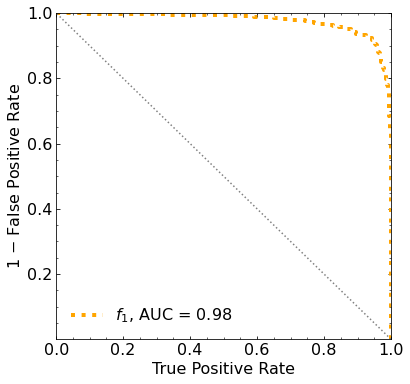

Classification score:


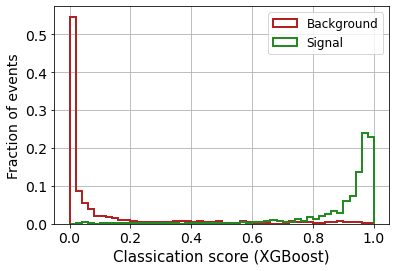


 ROC-AUC =  0.9768587517669474


In [157]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train_1D,y_mon_train,eval_set=[(X_mon_train_1D, y_mon_train), (X_mon_val_1D, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test_1D).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [158]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9768587517669474


In [159]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, B_expected, range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  13 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  13
range of our data:  [[0, 1]]


In [160]:
num_bins = 10

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2495


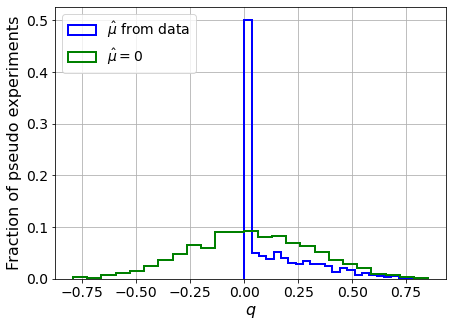

muhat mean:  0.038536636263196686
Z_bins:  0.18158143507907695
std Z_bins:  0.48998128447503086
Z_bins mu=0:  0.1810195155655162
std Z_bins mu=0:  0.7850378718242665

--------

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.252


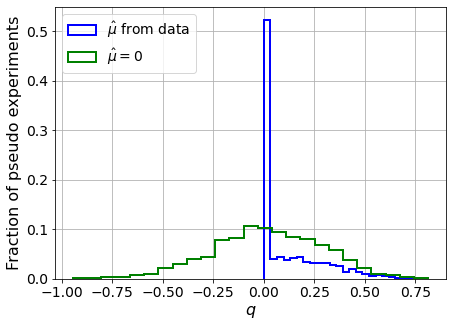

muhat mean:  0.2443002378995456
Z_bins:  0.14425061287656357
std Z_bins:  0.5657917541336488
Z_bins mu=0:  0.13469929940277953
std Z_bins mu=0:  1.0242836896365486

--------

B_expected:  643
S_expected:  2

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2725


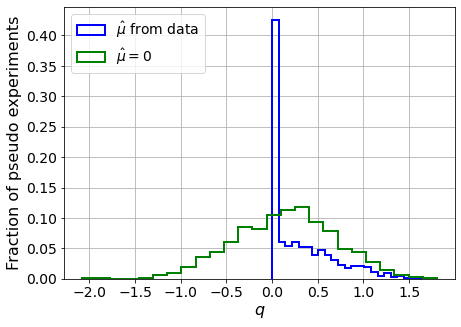

muhat mean:  0.020892323684567848
Z_bins:  0.412923742313449
std Z_bins:  0.4337863618686748
Z_bins mu=0:  0.412923742313449
std Z_bins mu=0:  0.6657356769139625

--------

B_expected:  643
S_expected:  3

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2635


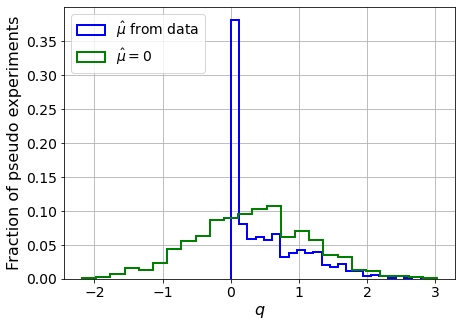

muhat mean:  0.022062251346733064
Z_bins:  0.5699640386815399
std Z_bins:  0.5078691630674962
Z_bins mu=0:  0.5699640386815399
std Z_bins mu=0:  0.7246591290636052

--------

B_expected:  643
S_expected:  7

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.257


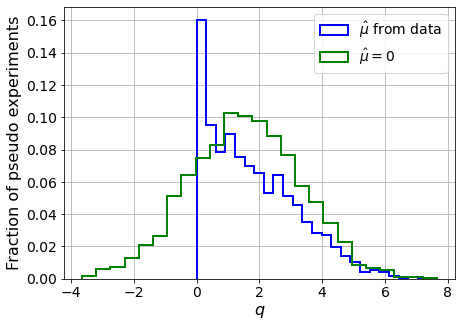

muhat mean:  0.012997977922843336
Z_bins:  1.2417148990733622
std Z_bins:  0.5736875549699081
Z_bins mu=0:  1.2416742640721028
std Z_bins mu=0:  0.7126068404327692

--------

B_expected:  643
S_expected:  15

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2675


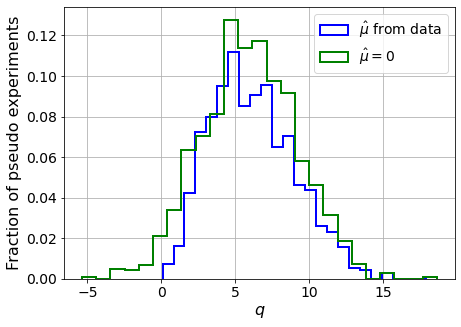

muhat mean:  0.011379373622958643
Z_bins:  2.4342934894824246
std Z_bins:  0.5793389417070186
Z_bins mu=0:  2.4338416925673507
std Z_bins mu=0:  0.6529171753833986

--------

B_expected:  643
S_expected:  33

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.252


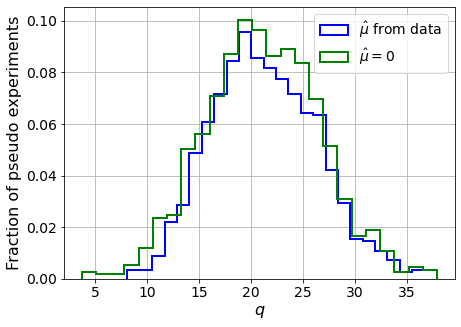

muhat mean:  0.010271640353837763
Z_bins:  4.591411540443888
std Z_bins:  0.5578130630266404
Z_bins mu=0:  4.590848927679305
std Z_bins mu=0:  0.5986281399991041

--------

B_expected:  643
S_expected:  72

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2595


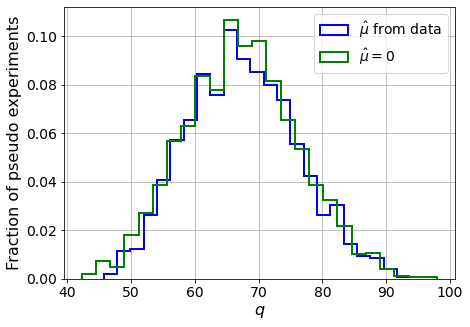

muhat mean:  0.001567383988873126
Z_bins:  8.184579852872739
std Z_bins:  0.5239797521877951
Z_bins mu=0:  8.184558605191874
std Z_bins mu=0:  0.5448551419290966

--------

B_expected:  643
S_expected:  154

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2555


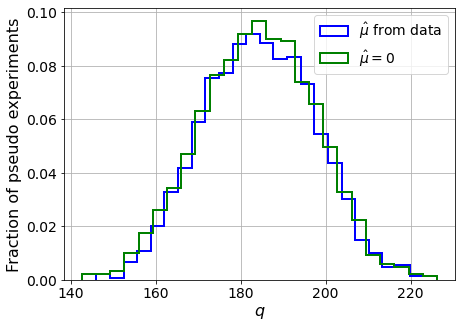

muhat mean:  0.001034364426062058
Z_bins:  13.572826270940384
std Z_bins:  0.4816675867703721
Z_bins mu=0:  13.572243087407694
std Z_bins mu=0:  0.4960515443736805

--------

B_expected:  643
S_expected:  332

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.273


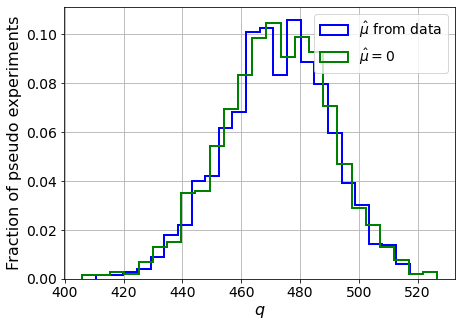

muhat mean:  0.00042292376067725894
Z_bins:  21.737084006266386
std Z_bins:  0.41792213592185773
Z_bins mu=0:  21.736132872310442
std Z_bins mu=0:  0.4271469483470706

--------


 FINAL RESULT:

[[0.18158143507907695, 0.48998128447503086, 0.038536636263196686, 0.1810195155655162, 0.7850378718242665], [0.14425061287656357, 0.5657917541336488, 0.2443002378995456, 0.13469929940277953, 1.0242836896365486], [0.412923742313449, 0.4337863618686748, 0.020892323684567848, 0.412923742313449, 0.6657356769139625], [0.5699640386815399, 0.5078691630674962, 0.022062251346733064, 0.5699640386815399, 0.7246591290636052], [1.2417148990733622, 0.5736875549699081, 0.012997977922843336, 1.2416742640721028, 0.7126068404327692], [2.4342934894824246, 0.5793389417070186, 0.011379373622958643, 2.4338416925673507, 0.6529171753833986], [4.591411540443888, 0.5578130630266404, 0.010271640353837763, 4.590848927679305, 0.5986281399991041], [8.184579852872739, 0.5239797521877951, 0.001567383988873126, 8.18455860519187

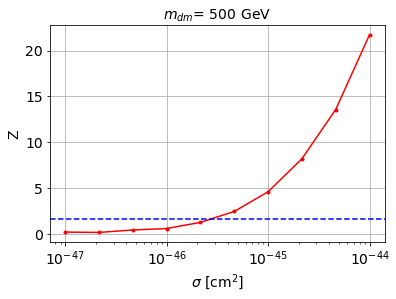


cross_BL_164:  2.783918794633224e-46
cross_BL_164_up:  1.7949932989563293e-46
cross_BL_164_down:  4.039237871101826e-46


In [161]:
# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []


for s_it in range(len(S_expected)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[s_it])
    print('')

    Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, S_expected[s_it], num_pseudo, num_bins, range_dat, MIN_EVS, linear_bins=True) 
    
    store_Z_BL.append( list(Z_BL) )
    
    print('muhat mean: ', Z_BL[2])
    print('Z_bins: ', Z_BL[0])
    print('std Z_bins: ', Z_BL[1])
    print('Z_bins mu=0: ', Z_BL[3])
    print('std Z_bins mu=0: ', Z_BL[4])
    print('')
    print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)


# plot
plt.plot(cross_factor*1e-45, np.array(store_Z_BL)[:,0], '.-', c='red')

plt.axhline(y=1.64, c='blue', linestyle='--')
plt.title('$m_{dm}$= %0.2d GeV' % mDM, fontsize=14)
plt.xscale('log')
plt.xlabel(r'$\sigma$ [cm$^2$]', fontsize=14)
plt.ylabel(r'Z', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()


# interpolate
f_Z = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0], kind='linear')
f_Z_up = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] + np.array(store_Z_BL)[:,1], kind='linear')
f_Z_down = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] - np.array(store_Z_BL)[:,1], kind='linear')

# compute the cross section with Z=1.64
cross_BL_164 = 10**solvecross(f_Z, 1.64)
cross_BL_164_up = 10**solvecross(f_Z_up, 1.64)
cross_BL_164_down = 10**solvecross(f_Z_down, 1.64)

print('\ncross_BL_164: ', cross_BL_164)
print('cross_BL_164_up: ', cross_BL_164_up)
print('cross_BL_164_down: ', cross_BL_164_down)

### DNN

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_122 (Dense)            (None, 64)                361280    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dropout_99 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_123 (Dense)            (None, 16)                1040      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dropout_100 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_124 (Dense)            (None, 4)               

50/50 [==============================] - 0s 2ms/step - loss: 0.2436 - accuracy: 0.9084 - val_loss: 0.2817 - val_accuracy: 0.8702
Epoch 47/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2309 - accuracy: 0.9093 - val_loss: 0.2130 - val_accuracy: 0.9076
Epoch 48/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2479 - accuracy: 0.9122 - val_loss: 0.1976 - val_accuracy: 0.9191
Epoch 49/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2467 - accuracy: 0.9060 - val_loss: 0.2478 - val_accuracy: 0.8836
Epoch 50/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2523 - accuracy: 0.8995 - val_loss: 0.2095 - val_accuracy: 0.9120
Epoch 51/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2463 - accuracy: 0.9099 - val_loss: 0.2067 - val_accuracy: 0.9173
Epoch 52/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2355 - accuracy: 0.9104 - val_loss: 0.2072 - val_accuracy: 0.9173
Epoch 53/1500

50/50 [==============================] - 0s 2ms/step - loss: 0.2271 - accuracy: 0.9146 - val_loss: 0.1996 - val_accuracy: 0.9218
Epoch 104/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.2082 - accuracy: 0.9255 - val_loss: 0.1965 - val_accuracy: 0.9164
Epoch 105/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2220 - accuracy: 0.9205 - val_loss: 0.2026 - val_accuracy: 0.9147
Epoch 106/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2088 - accuracy: 0.9221 - val_loss: 0.2207 - val_accuracy: 0.9164
Epoch 107/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2085 - accuracy: 0.9137 - val_loss: 0.2015 - val_accuracy: 0.9147
Epoch 108/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2208 - accuracy: 0.9129 - val_loss: 0.1954 - val_accuracy: 0.9209
Epoch 109/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2240 - accuracy: 0.9132 - val_loss: 0.2083 - val_accuracy: 0.9111
Epoch 1

Epoch 160/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.2097 - accuracy: 0.9153 - val_loss: 0.2022 - val_accuracy: 0.9200
Epoch 161/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2152 - accuracy: 0.9209 - val_loss: 0.1911 - val_accuracy: 0.9209
Epoch 162/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2042 - accuracy: 0.9240 - val_loss: 0.1929 - val_accuracy: 0.9191
Epoch 163/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1991 - accuracy: 0.9208 - val_loss: 0.1937 - val_accuracy: 0.9191
Epoch 164/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2076 - accuracy: 0.9186 - val_loss: 0.2050 - val_accuracy: 0.9227
Epoch 165/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2122 - accuracy: 0.9199 - val_loss: 0.2037 - val_accuracy: 0.9084
Epoch 166/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2098 - accuracy: 0.9148 - val_loss: 0.1937 - val_accuracy:

Epoch 217/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1988 - accuracy: 0.9164 - val_loss: 0.1874 - val_accuracy: 0.9147
Epoch 218/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1895 - accuracy: 0.9293 - val_loss: 0.1852 - val_accuracy: 0.9173
Epoch 219/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1900 - accuracy: 0.9260 - val_loss: 0.1909 - val_accuracy: 0.9209
Epoch 220/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1905 - accuracy: 0.9265 - val_loss: 0.1923 - val_accuracy: 0.9182
Epoch 221/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1905 - accuracy: 0.9220 - val_loss: 0.1871 - val_accuracy: 0.9218
Epoch 222/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1900 - accuracy: 0.9327 - val_loss: 0.1951 - val_accuracy: 0.9129
Epoch 223/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.2027 - accuracy: 0.9221 - val_loss: 0.1932 - val_accuracy:

Epoch 274/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1910 - accuracy: 0.9287 - val_loss: 0.1989 - val_accuracy: 0.9013
Epoch 275/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1791 - accuracy: 0.9292 - val_loss: 0.1922 - val_accuracy: 0.9173
Epoch 276/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1807 - accuracy: 0.9294 - val_loss: 0.1897 - val_accuracy: 0.9191
Epoch 277/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1911 - accuracy: 0.9307 - val_loss: 0.2245 - val_accuracy: 0.8987
Epoch 278/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1876 - accuracy: 0.9253 - val_loss: 0.1904 - val_accuracy: 0.9164
Epoch 279/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.1926 - accuracy: 0.9261 - val_loss: 0.1928 - val_accuracy: 0.9173
Epoch 280/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1964 - accuracy: 0.9229 - val_loss: 0.1855 - val_accuracy:

Epoch 331/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.1942 - accuracy: 0.9263 - val_loss: 0.1856 - val_accuracy: 0.9218
Epoch 332/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1758 - accuracy: 0.9303 - val_loss: 0.1890 - val_accuracy: 0.9209
Epoch 333/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1907 - accuracy: 0.9305 - val_loss: 0.1897 - val_accuracy: 0.9253
Epoch 334/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1914 - accuracy: 0.9272 - val_loss: 0.1916 - val_accuracy: 0.9227
Epoch 335/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1853 - accuracy: 0.9278 - val_loss: 0.1843 - val_accuracy: 0.9280
Epoch 336/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1877 - accuracy: 0.9246 - val_loss: 0.1836 - val_accuracy: 0.9271
Epoch 337/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.1901 - accuracy: 0.9265 - val_loss: 0.1847 - val_accuracy:

Epoch 388/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1734 - accuracy: 0.9335 - val_loss: 0.1847 - val_accuracy: 0.9236
Epoch 389/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1761 - accuracy: 0.9329 - val_loss: 0.1907 - val_accuracy: 0.9218
Epoch 390/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1836 - accuracy: 0.9291 - val_loss: 0.1877 - val_accuracy: 0.9253
Epoch 391/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.1785 - accuracy: 0.9288 - val_loss: 0.1852 - val_accuracy: 0.9262
Epoch 392/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1770 - accuracy: 0.9318 - val_loss: 0.1854 - val_accuracy: 0.9253
Epoch 393/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1824 - accuracy: 0.9296 - val_loss: 0.1824 - val_accuracy: 0.9289
Epoch 394/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.1702 - accuracy: 0.9316 - val_loss: 0.1928 - val_accuracy:

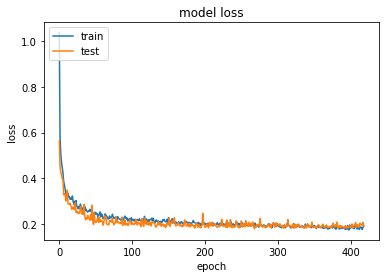

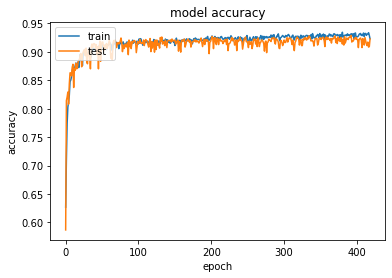

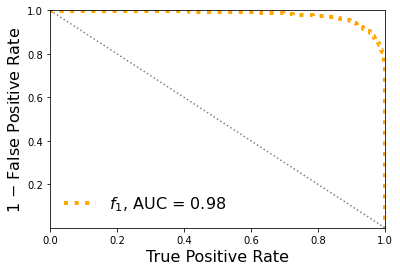

Classification score:


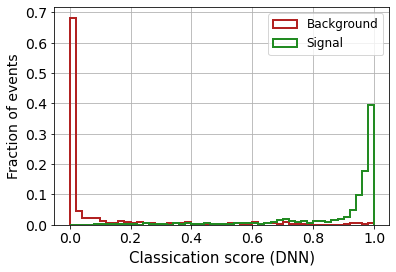


 ROC-AUC =  0.9801781799930347


In [162]:

# define the keras model
model = Sequential()
model.add(Dense(64, input_shape=(X_mon_train_1D.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train_1D,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_1D, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test_1D)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [163]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9801781799930347


### CNN

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 2,656,977
Trainable params: 2,656,977
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/500
50/50 [==============================] - 5s 96ms/step - loss: 1.8556 - accuracy: 0.7995 - val_loss: 0.9094 - val_accuracy: 0.7956
Epoch 2/500
50/50 [==============================] - 5s 94ms/step - loss: 0.6173 - accuracy: 0.8471 - val_loss: 0.6308 - val_accuracy: 0.8462
Epoch 3/500
50/50 [==============================] - 5s 94ms/step - loss: 0.4874 - accuracy: 0.8670 - val_loss: 0.4622 - val_accuracy: 0.8800
Epoch 4/500
50/50 [==============================] - 5s 95ms/step - loss: 0.4034 - accuracy: 0.8889 - val_loss: 0.4087 - val_accuracy: 0.8827
Epoch 5/500
50/50 [=======================

Epoch 55/500
50/50 [==============================] - 4s 87ms/step - loss: 0.0834 - accuracy: 0.9693 - val_loss: 0.3353 - val_accuracy: 0.8942
Epoch 56/500
50/50 [==============================] - 4s 86ms/step - loss: 0.0905 - accuracy: 0.9652 - val_loss: 0.3910 - val_accuracy: 0.8880
Epoch 57/500
50/50 [==============================] - 4s 87ms/step - loss: 0.0946 - accuracy: 0.9619 - val_loss: 0.3465 - val_accuracy: 0.8978
Epoch 58/500
50/50 [==============================] - 4s 88ms/step - loss: 0.0812 - accuracy: 0.9685 - val_loss: 0.3533 - val_accuracy: 0.8942
Epoch 59/500
50/50 [==============================] - 4s 86ms/step - loss: 0.0678 - accuracy: 0.9744 - val_loss: 0.3561 - val_accuracy: 0.8996
Epoch 60/500
50/50 [==============================] - 4s 86ms/step - loss: 0.0566 - accuracy: 0.9816 - val_loss: 0.3869 - val_accuracy: 0.8916
Epoch 61/500
50/50 [==============================] - 4s 87ms/step - loss: 0.0590 - accuracy: 0.9785 - val_loss: 0.3836 - val_accuracy: 0.8933

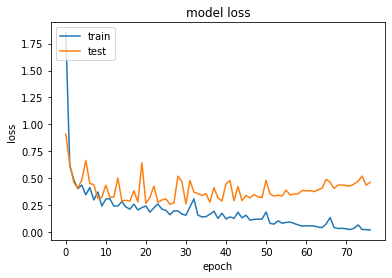

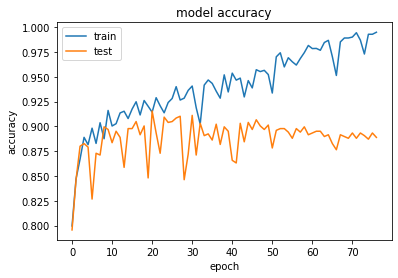

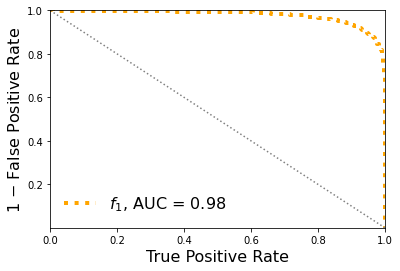

Classification score:


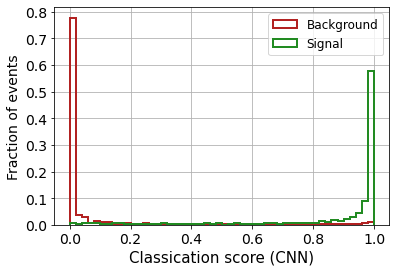


 ROC-AUC =  0.9767825681683158


In [164]:
##########
# images #
##########

input_2d = Input(shape=(X_mon_train.shape[1],X_mon_train.shape[2],X_mon_train.shape[3]))

# Conv1D network
conv2d = Conv2D(16, (3,3), strides = (1),kernel_regularizer=l2(0.005))(input_2d)
conv2d = keras.layers.LeakyReLU(alpha=0.05)(conv2d)
conv2d = MaxPooling2D((2,2), strides = (1,1))(conv2d)

conv2d = Dropout(0.20)(conv2d)
conv2d = Flatten()(conv2d)

conv2d = Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d)
conv2d = keras.layers.LeakyReLU(alpha=0.05)(conv2d)
conv2d = Dropout(0.2)(conv2d)



############
# features #
############

input_1d = Input(shape=(X_mon5_train.shape[1]))



# Concatenate the outputs from Conv2D and Conv1D networks
combined = concatenate([conv2d, input_1d])


# Dense layers
dense = Dense(32, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_2d, input_1d], outputs=output)

# Print the model summary
model.summary()




# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit([X_mon_train,X_mon5_train],
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon_val,X_mon5_val], y_mon_val),
                    shuffle=True)



# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict([X_mon_test,X_mon5_test])

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [165]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9767825681683158
